# 미니 프로젝트 : SRGAN 활용
## 1. SRGAN 실험
## 2. SRGAN을 이용해 고해상도 gif 생성

----
# 직접 고른 이미지로 SRGAN 실험

# 프로젝트 1-1
__전체 과정__
- __(1)__ (적당히) 높은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러온다.
- __(2)__ 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 1/4로 줄인다.
- __(3)__ 줄인 저해상도 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성한다. 
- __(4)__ 2.의 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘린다.
- __(5)__ 3개 이미지 (4).의 Bicubic의 결과, (3).의 SRGAN의 결과, (1).의 원래 고해상도 이미지)를 나란히 시각화한다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시한다.
- __(6)__ 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명한다.

In [28]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

####  (1) (적당히) 높은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러온다.

(1280, 1920, 3)


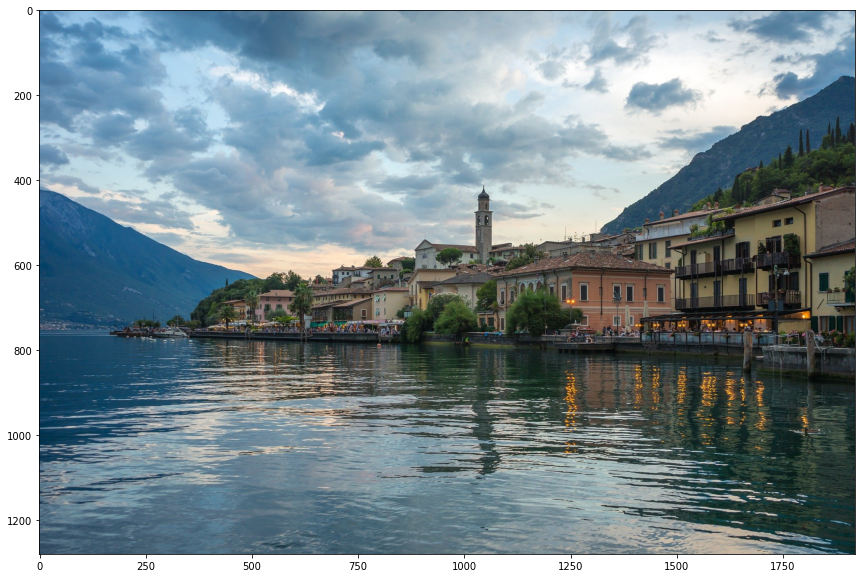

In [2]:
# 고해상도 이미지 불러오기
hr_image = cv2.imread('EP16_data/pic_high.jpg')
hr_image = cv2.cvtColor(hr_image, cv2.COLOR_BGR2RGB)

print(hr_image.shape)

plt.figure(figsize=(20,10))
plt.imshow(hr_image)

#### (2) 불러온 이미지의 가로 및 세로 픽셀 수를 1/4로 줄인다.

(320, 480, 3)


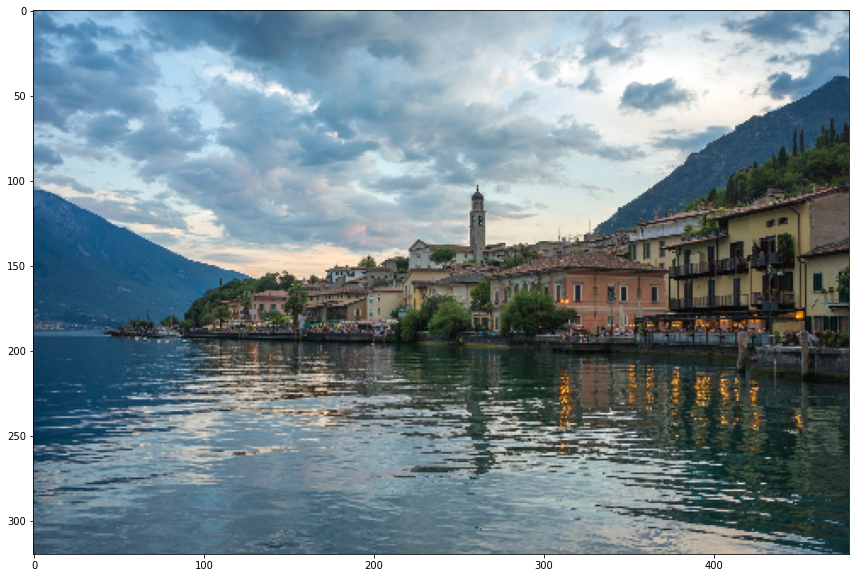

In [3]:
# 이미지 사이즈 줄이기
lr_image = cv2.resize(
    hr_image,
    dsize=(hr_image.shape[1]//4, hr_image.shape[0]//4)
)

print(lr_image.shape)

plt.figure(figsize=(20,10))
plt.imshow(lr_image)

#### (3) 줄인 저해상도 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성한다.

In [4]:
# pre-trained 모델 로드
model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

In [5]:
# SRGAN으로 고해상도 이미지 생성
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

train, valid = tfds.load(
    "div2k/bicubic_x4", 
    split=["train","validation"],
    as_supervised=True
)

for i, (lr, hr) in enumerate(valid):
    if i == 6: break

srgan_hr = apply_srgan(lr_image)

In [6]:
srgan_hr = apply_srgan(lr_image)

#### (4) 2.의 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘린다.

In [7]:

# bicubic interpolation으로 이미지 사이즈 키우기
bicubic_hr = cv2.resize(
    lr_image, 
    dsize=(hr_image.shape[1], hr_image.shape[0]), # 고해상도 이미지 크기로 설정
    interpolation=cv2.INTER_CUBIC # bicubic 설정
)

####  __(5)__ 3개 이미지 (4).의 Bicubic의 결과, (3).의 SRGAN의 결과, (1).의 원래 고해상도 이미지)를 나란히 시각화한다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시한다.

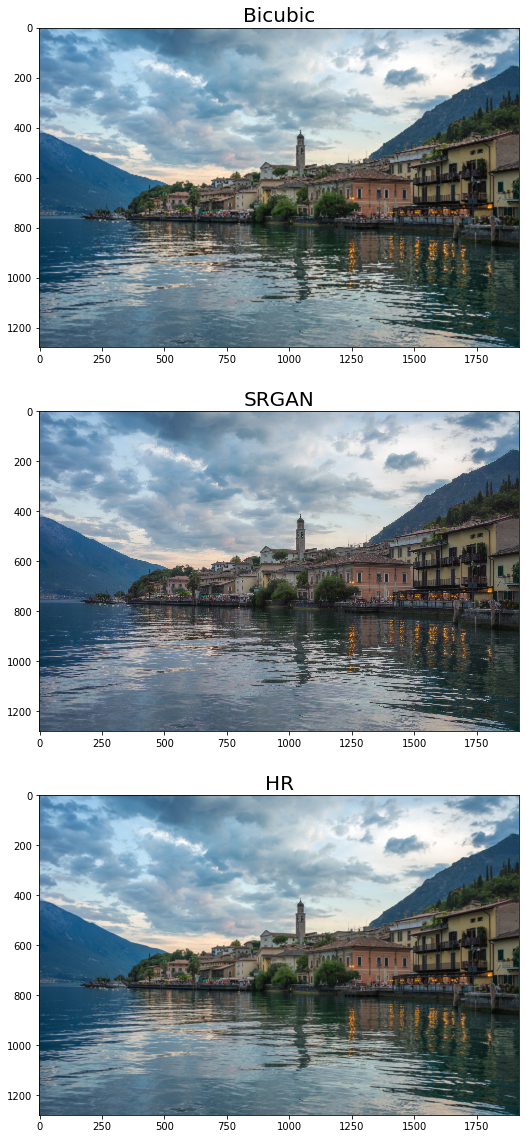

In [17]:
# 시각화
images = [bicubic_hr, srgan_hr, hr_image]
titles = ["Bicubic", "SRGAN", "HR"]

plt.figure(figsize=(20,20))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(3,1,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

In [9]:
# 이미지의 특정 부분을 잘라내는 함수를 정의합니다.
def crop(image, left_top, x=200, y=200):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

In [29]:
def compare_img(x,y):
    left_top = (x,y)
    crop_bicubic_hr = crop(bicubic_hr, left_top)
    crop_srgan_hr = crop(srgan_hr, left_top)
    crop_hr = crop(hr_image, left_top)
    
    
    # 각 이미지에 대해 PSNR을 계산하고 반올림합니다.
    psnr_bicubic = round(peak_signal_noise_ratio(crop_hr, crop_bicubic_hr), 3)
    psnr_srgan = round(peak_signal_noise_ratio(crop_hr, crop_srgan_hr), 3)
    
    # 각 이미지에 대해 SSIM을 계산하고 반올림합니다.
    ssim_bicubic = round(structural_similarity(crop_hr, crop_bicubic_hr, multichannel=True), 3)
    ssim_srgan = round(structural_similarity(crop_hr, crop_srgan_hr, multichannel=True), 3)

    # 잘라낸 부분을 시각화 합니다.
    plt.figure(figsize=(15,25))
    plt.subplot(1,3,1); plt.imshow(crop_bicubic_hr); plt.title(f"Bicubic [{psnr_bicubic}/{ssim_bicubic}]", fontsize=20)
    plt.subplot(1,3,2); plt.imshow(crop_srgan_hr); plt.title(f"SRGAN [{psnr_srgan}/{ssim_srgan}]", fontsize=20)
    plt.subplot(1,3,3); plt.imshow(crop_hr); plt.title("HR", fontsize=20)

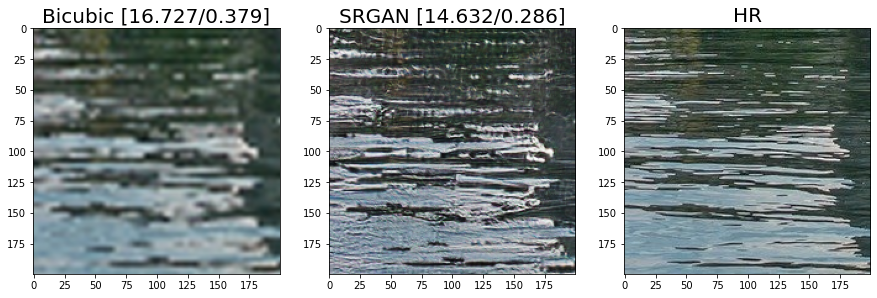

In [30]:
compare_img(850,850)

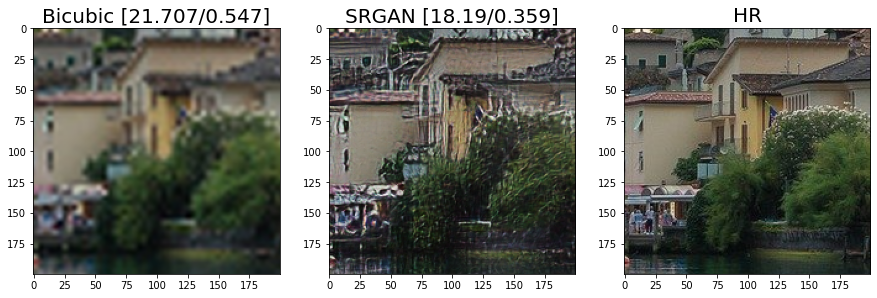

In [31]:
compare_img(600,800)

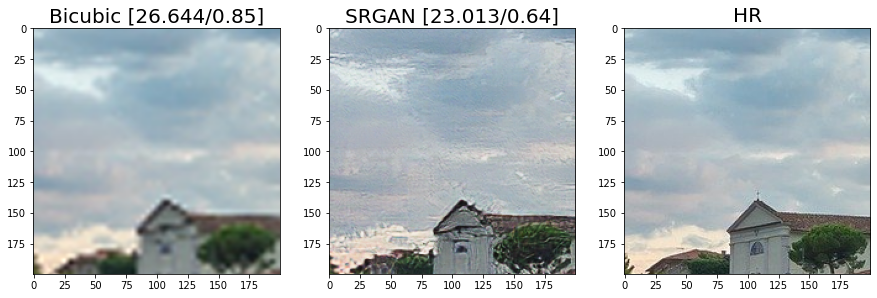

In [32]:
compare_img(400,800)

#### (6) 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명한다.

생성된 Bicubic 이미지와 SRGAN 이미지를  원래의 HR 이미지와 비교해보면  
- Bicubic 이미지의 경우, HR 이미지보다 해상도가 많이 떨어지는 것을 알 수 있다.
- SRGAN 이미지의 경우, 크게 보면 Bicubic 이미지보다 해상도가 좋아진 것 같은 느낌이 든다. 하지만 특정 부분을 잘라 자세히 보았을때 노이즈같은것이 발견된다.
- PSNR, SSIM 값의 경우 Bicubic 이미지가 SRGAN 이미지 보다 높은 것을 알 수 있다.

----
# 프로젝트 1-2
__전체 과정__
- __(1)__ (적당히) 낮은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러온다.
- __(2)__  불러온 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성한다.
- __(3)__  1.에서 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘린다.
- __(4)__  2개 이미지(3.의 Bicubic의 결과, 2.의 SRGAN의 결과)를 나란히 시각화한다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시한다.
- __(5)__  선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명한다.

In [33]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

#### (1) (적당히) 낮은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러온다.

(256, 256, 3)


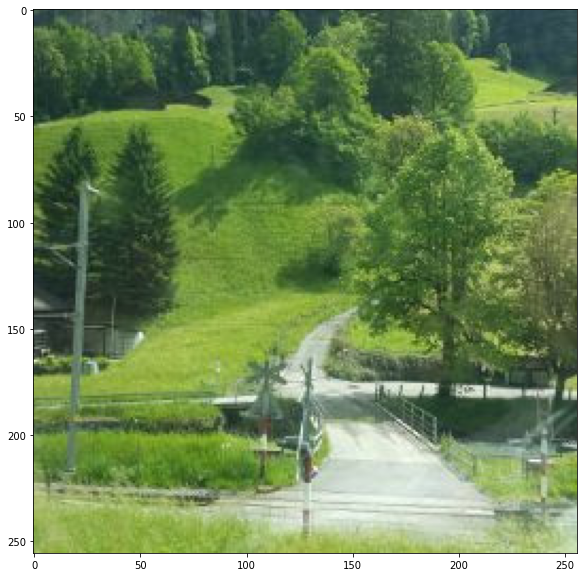

In [37]:
# 저해상도 이미지 불러오기
lr_image = cv2.imread('EP16_data/pic_low.jpg')
lr_image = cv2.cvtColor(lr_image, cv2.COLOR_BGR2RGB)

print(lr_image.shape)

plt.figure(figsize=(20,10))
plt.imshow(lr_image)

#### (2) 불러온 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성한다.

In [38]:
# SRGAN으로 고해상도 이미지 생성
srgan_hr = apply_srgan(lr_image)

#### (3) 1.에서 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘린다.

In [39]:
# bicubic interpolation으로 이미지 사이즈 키우기
bicubic_hr = cv2.resize(
    lr_image, 
    dsize=(lr_image.shape[1]*4, lr_image.shape[0]*4), # 고해상도 이미지 크기로 설정
    interpolation=cv2.INTER_CUBIC # bicubic 설정
)

#### (4) 2개 이미지(3.의 Bicubic의 결과, 2.의 SRGAN의 결과)를 나란히 시각화한다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시한다.

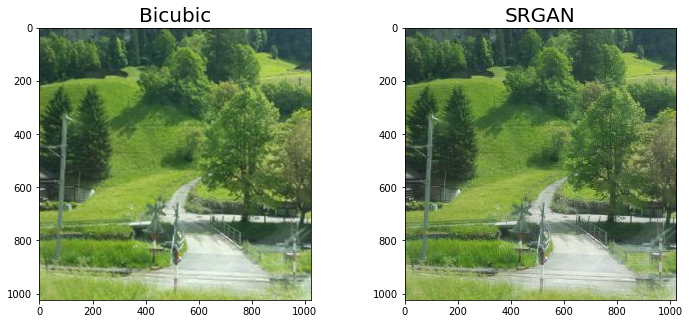

In [41]:
# 시각화
images = [bicubic_hr, srgan_hr]
titles = ["Bicubic", "SRGAN"]

plt.figure(figsize=(12,5))
for i, (lr_image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,2,i+1)
    plt.imshow(lr_image)
    plt.title(title, fontsize=20)

In [66]:
def compare_lr_img(x,y):
    left_top = (x,y)
    crop_bicubic_hr = crop(bicubic_hr, left_top)
    crop_srgan_hr = crop(srgan_hr, left_top)
    

    # 잘라낸 부분을 시각화 합니다.
    plt.figure(figsize=(12,15))
    plt.subplot(1,2,1); plt.imshow(crop_bicubic_hr); plt.title("Bicubic", fontsize=20)
    
    plt.subplot(1,2,2); plt.imshow(crop_srgan_hr); plt.title("SRGAN", fontsize=20)

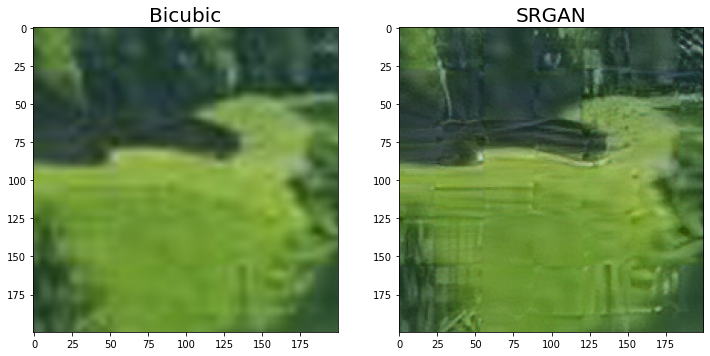

In [67]:
compare_lr_img(100,200)

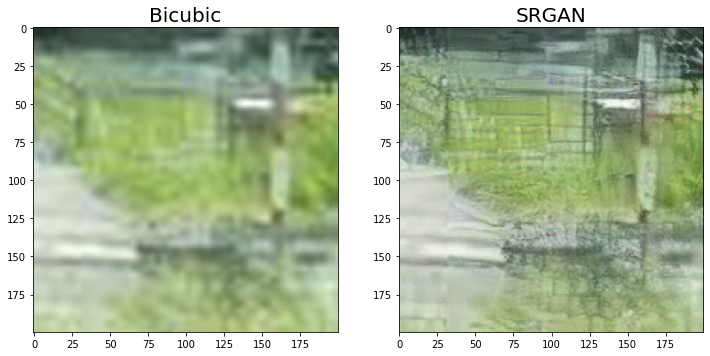

In [68]:
compare_lr_img(800,800)

#### (5) 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명한다.

Bicubic 이미지와 SRGAN 이미지를 비교해보았을때, BIcubic 이미지는 흐릿한 느낌이 더 드는 반면, SRGAN 이미지는 흐릿하지는 않지만 이미지가 부자연스러운 모습을 보이는 것을 확인 할 수 있다.

----
# 프로젝트 2 : SRGAN을 이용해 고해상도 gif 생성